## Part 3: Environmental Benifits of Transit

Assume that each driveway has two cars and that all people work in downtown Kingston, how many new
bus routes are needed to make people leave their cars at home? How much would that reduce the gas
emissions (make your own reasonable assumptions)?


### Calculating commuting distance

Assumptions:

1. All people work in downtown Kingston, for simplicity the downtown tranfer station is taken as the destination coorditates for every person's commute.

2. Each driveway has two cars, driveway coorditates are taken from the "driveways" dataset from the City of Kingston.

3. New bus routes will added from the centroid of each neighbourhood to the downtown tranfer point.

4. A conversion factor of 1.3 is used to compensate for the use of euclidean distances.

5. The capacity of a transit bus is 76 (https://www.dimensions.com/element/city-transit-buses)

6. The average fuel efficiency of the commuting vehicles is 8.9L/100km (11.286 km/l) (https://www.cer-rec.gc.ca/en/data-analysis/energy-markets/market-snapshots/2019/market-snapshot-how-does-canada-rank-in-terms-vehicle-fuel-economy.html#:~:text=In%202017%2C%20Canada%27s%20average,kilometres%20(L%2F100km).&text=In%20comparison%2C%20fuel%20consumption%20averaged,4.9%20L%2F100km%20in%20Portugal.)

7. Fuel efficiency of a transit bus is 3.26 mpg (1.4878 km/l) (https://www.bts.gov/content/bus-fuel-consumption-and-travel-metric)

8. All cars use gasoline as fuel, producing 2.29 kg of CO2 per liter of consumption. (https://www.nrcan.gc.ca/sites/www.nrcan.gc.ca/files/oee/pdf/transportation/fuel-efficient-technologies/autosmart_factsheet_6_e.pdf)

9. All transit busses use deisel as fuel, producing 2.66 kg CO2 per liter of consumption. (https://www.nrcan.gc.ca/sites/www.nrcan.gc.ca/files/oee/pdf/transportation/fuel-efficient-technologies/autosmart_factsheet_6_e.pdf)

In [296]:
import pandas as pd
from geopy.distance import distance
import missingno as miss
plt.style.use('fivethirtyeight')
%matplotlib inline
%cd "C:\Users\mcunningham\Documents\PythonProjects\CISC451\Datasets"

C:\Users\mcunningham\Documents\PythonProjects\CISC451\Datasets


In [297]:
# load points of interest dataset
df = pd.read_csv("point-of-interest.csv", ';')
# Get the downtown transfer point's coordinates
downtown_point = df.loc[df['NAME'] == 'DOWNTOWN TRANSFER POINT', 'geo_point_2d'].values[0]
# convert to a tuple of floats
downtown_lon = float(downtown_point.split(',')[0])
downtown_lat = float(downtown_point.split(',')[1])
downtown_coords = (downtown_lon, downtown_lat)
print(downtown_coords)

(44.2310329063, -76.4845381585)


#### Cleaning the driveway dataset

In [298]:
df = pd.read_csv("driveways.csv", ';')
df.isna().sum()


﻿&quot;STATUS&quot;       2
MATERIAL        1
GeoJSON         3
geo_point_2d    3
dtype: int64

We only want active driveways so we filter for those, and then check for any missing values.

In [299]:
df.drop(df[df[df.keys()[0]] != 'ACTIVE'].index, inplace=True)
df.isna().sum()

﻿&quot;STATUS&quot;       0
MATERIAL        0
GeoJSON         3
geo_point_2d    3
dtype: int64

Since there are only three missing values, we decided to drop the rows

In [300]:
df.dropna(inplace=True)
df.isna().sum()

﻿&quot;STATUS&quot;       0
MATERIAL        0
GeoJSON         0
geo_point_2d    0
dtype: int64

Now we convert the "geo_point_2d" column into a list of tuples containing latitude and longitude coordinates of type float.

In [301]:
driveway_coords = df['geo_point_2d'].str.split(',', expand=True).astype(float).rename(columns={0:'Latitude', 1:'Longitude'})
driveway_coords_tuples = zip(driveway_coords['Latitude'], driveway_coords['Longitude'])
print(len(driveway_coords))

45296


Now we calculate which neighbourhood each driveway is located within.

In [302]:
from turfpy.measurement import boolean_point_in_polygon, centroid, distance
from geojson import Point, MultiPolygon, Polygon, Feature, load
from pprint import pprint
%cd "C:\Users\mcunningham\Documents\PythonProjects\CISC451"

C:\Users\mcunningham\Documents\PythonProjects\CISC451


Load neighbourhood geojson and calculate the centroid as well as the distance between the centroid and the downtown transfer point.

In [303]:
with open("A1_geo\\neighbourhoods.geojson") as n:
    neighbourhoods = load(n)
# Create geojson feature for the downtown transit point
dt = Feature(geometry=Point((downtown_coords[1], downtown_coords[0])))
for neighbourhood in neighbourhoods['features']:
    # neighbourhood['polygon'] = Feature(geometry=Polygon(neighbourhood.geometry.coordinates))
    # Create keys in neighbourhoods dict for key metrics
    neighbourhood['properties']['driveway_count'] = 0
    neighbourhood['properties']['commuter_distance'] = 0
    # Calculate centroid of each neighbourhood
    neighbourhood['properties']['centroid'] = centroid(neighbourhood)
    # Calculate the distance between the neighbourhood centroid and the downtown transfer point
    neighbourhood['properties']['distance_to_downtown'] = distance(neighbourhood['properties']['centroid'], dt) * 1.3
    # output
    print(f"{neighbourhood['properties']['name']}\nCentroid: {neighbourhood['properties']['centroid']}\nDistance: {neighbourhood['properties']['distance_to_downtown']}")

Marker&#39;s Acres
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.464708, 44.273464], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 6.46808412100974
Polson Park
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.532533, 44.234207], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 4.992192402
Reddendale
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.564105, 44.21394], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 8.604916790633462
Rideau Heights
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.462188, 44.265945], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 5.551987837658764
Williamsville
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.49947

Assumptions:

1. There are 2 cars for every driveway in Kingston

2. A conversion factor of 1.3 is used to compensate for the use of euclidean distances

In [304]:

for driveway in zip(driveway_coords['Longitude'], driveway_coords['Latitude']):
    # convert tuple to a geojson feature
    driveway = Feature(geometry=Point(driveway))
    # Check if driveway is located within each neighbourhood
    for neighbourhood in neighbourhoods['features']:
        if boolean_point_in_polygon(driveway, neighbourhood):
            # Increment driveway count for the neighbourhood
            neighbourhood['properties']['driveway_count'] += 1
            # Add up all the car milage for each driveway in the neighbourhood
            # (2 cars per driveway) 
            neighbourhood['properties']['commuter_distance'] += 2 * distance(driveway, dt) * 1.3
            break

Bus capacity taken from https://www.dimensions.com/element/city-transit-buses

In [305]:
from math import ceil
bus_seat_cap = 29
bus_total_cap = 76
# initiate lists for creating a dataframe
names = []
driveway_count = []
busses_required = []
commuting_distance = []
tansit_distance = []
# loop through neighbourhoods and calculate metrics
for neighbourhood in neighbourhoods['features']:
    prop = neighbourhood['properties']
    # Calculate how many busses are required to handle all commuters (2 people per driveway)
    prop['busses_required'] = ceil(prop['driveway_count'] * 2 / bus_total_cap)
    # Calculate how many km will be traveled by these busses
    prop['transit_stand_distance'] = prop['busses_required'] * prop['distance_to_downtown']
    # Output metrics
    print(
        f"{prop['name']}\n"
        f"Driveways:\t\t\t\t{prop['driveway_count']}\n"
        f"Commute Distance (km):\t\t\t{prop['commuter_distance']}\n"
        f"Transit Distance Standing room (km):\t{prop['transit_stand_distance']}\n"
    )
    # Append values to lists to be used in DataFrame
    names.append(prop['name'])
    busses_required.append(prop['busses_required'])
    driveway_count.append(prop['driveway_count'])
    commuting_distance.append(prop['commuter_distance'])
    tansit_distance.append(prop['transit_stand_distance'])

Marker&#39;s Acres
Driveways:				1080
Commute Distance (km):			12046.197025131267
Transit Distance Standing room (km):	187.57443950928246

Polson Park
Driveways:				398
Commute Distance (km):			3759.1643697537993
Transit Distance Standing room (km):	54.914116422

Reddendale
Driveways:				592
Commute Distance (km):			10846.383245070781
Transit Distance Standing room (km):	137.6786686501354

Rideau Heights
Driveways:				1363
Commute Distance (km):			11326.788345649604
Transit Distance Standing room (km):	199.8715621557155

Williamsville
Driveways:				453
Commute Distance (km):			1675.6173581923968
Transit Distance Standing room (km):	22.719053560659404

Alwington
Driveways:				425
Commute Distance (km):			2161.1377652922015
Transit Distance Standing room (km):	30.866391577168304

Fairway Hills
Driveways:				489
Commute Distance (km):			4969.576245235167
Transit Distance Standing room (km):	70.69759912597817

Westwoods
Driveways:				2220
Commute Distance (km):			54819.90102764282
Transit 

Create Datafrsme and plot results.

**Assumptions:**

1. Fuel ifficiency of the average car is 8.9L/100km (11.286 km/l) ()

2. Fuel efficiency of a city bus is 3.26 mpg (1.4878 km/l) (https://www.bts.gov/content/bus-fuel-consumption-and-travel-metric)

In [306]:
car_efficiency = 11.286
bus_efficiency = 1.4878
car_emissions = 2.29
bus_emissions = 2.66
# Create DataFrame
commute_df = pd.DataFrame({'Neighbourhood': names, 'Number of Driveways': driveway_count, 'Busses Required': busses_required, 'Commuting Distance': commuting_distance, 'Transit Distance': tansit_distance})
# Calculate commute/transit fuel consumption for each neighbourhood
commute_df['Commute Consumption'] = commute_df['Commuting Distance']/car_efficiency
commute_df['Transit Consumption'] = commute_df['Transit Distance']/car_efficiency
# And CO2 emissions
commute_df['Commute Emissions'] = commute_df['Commute Consumption'] * car_emissions
commute_df['Transit Emissions'] = commute_df['Transit Consumption'] * bus_emissions
commute_df.head()

,Neighbourhood,Number of Driveways,Busses Required,Commuting Distance,Transit Distance,Commute Consumption,Transit Consumption,Commute Emissions,Transit Emissions
0,Marker's Acres,1080,29,12046.197025,187.574440,1067.357525,16.620099,2444.248732,44.209464
1,Polson Park,398,11,3759.164370,54.914116,333.082081,4.865685,762.757966,12.942721
2,Reddendale,592,16,10846.383245,137.678669,961.047603,12.199067,2200.799010,32.449518
3,Rideau Heights,1363,36,11326.788346,199.871562,1003.614066,17.709690,2298.276210,47.107776
4,Williamsville,453,12,1675.617358,22.719054,148.468665,2.013030,339.993244,5.354659


&lt;AxesSubplot:xlabel=&#39;Neighbourhood&#39;&gt;

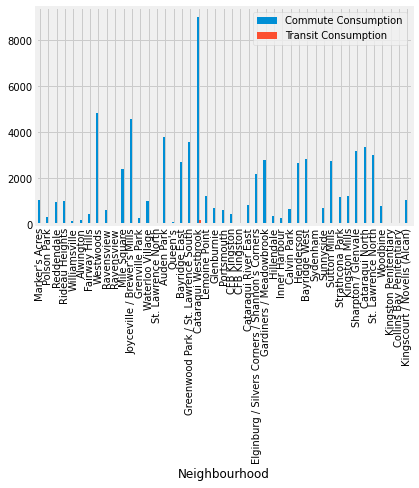

In [307]:
commute_df[['Neighbourhood', 'Commute Consumption', 'Transit Consumption']].plot.bar(x='Neighbourhood')

&lt;AxesSubplot:ylabel=&#39;None&#39;&gt;

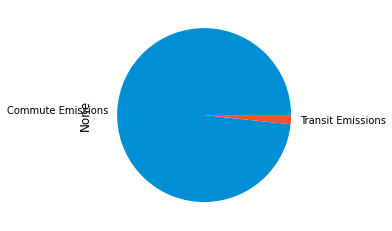

In [308]:
commute_df[['Commute Emissions', 'Transit Emissions']].sum().plot.pie()

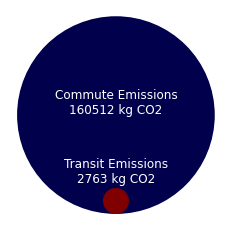

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection


def nested_circles(data, labels=None, c=None, ax=None, 
                   cmap=None, norm=None, textkw={}):
    """ Create a nested circles plot for for the given data
    """
    ax = ax or plt.gca()
    data = np.array(data)
    R = np.sqrt(data/data.max())
    p = [plt.Circle((0,r), radius=r) for r in R[::-1]]
    arr = data[::-1] if c is None else np.array(c[::-1])
    col = PatchCollection(p, cmap=cmap, norm=norm, array=arr)

    ax.add_collection(col)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.autoscale()

    if labels is not None:
        kw = dict(color="white", va="center", ha="center")
        kw.update(textkw)
        ax.text(0, R[0] + 0.3, labels[0], **kw)
        for i in range(1, len(R)):
            ax.text(0, R[i]+R[i-1], labels[i], **kw)
    return col
bus_emissions = commute_df['Transit Emissions'].sum()
car_emissions = commute_df['Commute Emissions'].sum()
data = [bus_emissions, car_emissions]
labels = [
    f'Transit Emissions\n{round(bus_emissions)} kg CO2',
    f'Commute Emissions\n{round(car_emissions)} kg CO2'
    ]
nested_circles(data, labels=labels, cmap="seismic_r", textkw=dict(fontsize=12))
plt.show()